In [1]:
##Dataset url: https://grouplens.org/datasets/movielens/latest/

import pandas as pd
import numpy as np


In [2]:

movies_df = pd.read_csv('/content/movies.csv',usecols=['movieId','title'],dtype={'movieId': 'int32', 'title': 'str'})
rating_df=pd.read_csv('/content/ratings.csv',usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
df = pd.merge(rating_df,movies_df,on='movieId')
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [6]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [7]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_with_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


Combining the left and right dataframe namely combine_movie_rating and movie_ratingCount giving more importance or merging on the dataset on the left, combine_movie_rating

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   9719.000
mean      10.375
std       22.406
min        1.000
25%        1.000
50%        3.000
75%        9.000
max      329.000
Name: totalRatingCount, dtype: float64


Setting the float to 3 decimal points in the total rating count column

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

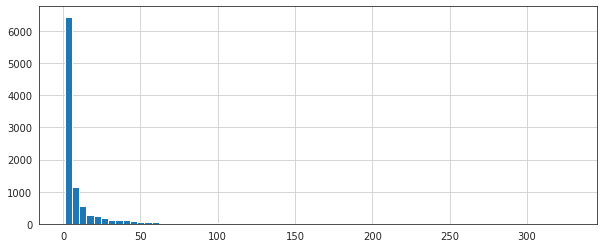

In [11]:
plt.figure(figsize=(10,4))
movie_ratingCount['totalRatingCount'].hist(bins=70)

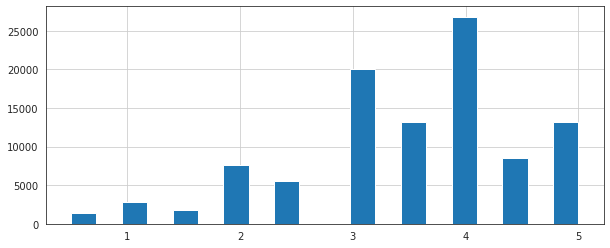

In [17]:
plt.figure(figsize=(10,4))
rating_with_totalRatingCount['rating'].hist(bins=20)

In [9]:
popularity_threshold = 50
rating_popular_movie= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()


,userId,movieId,rating,title,totalRatingCount
0,1,1,4.000,Toy Story (1995),215
1,5,1,4.000,Toy Story (1995),215
2,7,1,4.500,Toy Story (1995),215
3,15,1,2.500,Toy Story (1995),215
4,17,1,4.500,Toy Story (1995),215


Popularity threshold has been decided by using histogram of cell 11

In [18]:
rating_popular_movie.shape

(41362, 5)

In [19]:
## First lets create a Pivot matrix

movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,3.000,3.000,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,5.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,3.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,3.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,...,0.000,0.000,5.000,0.000,0.000,0.000,3.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,5.000,4.000,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,1.500,0.000,0.000,0.000,0.000,0.000,3.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,3.500,0.000,0.000,4.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000


Here, we see that the pivot matrix is the opposite of the one we have seen in the Correlation based content based recommendation where there was the user in the rows and movies in the features because we had to create user centric data wherein the movies series was correlated against each other for a particular user. Here in this case the user(feature) is polled against the movies and checked for similarity with the other users.(Nearest Neighbors)

In [20]:
##to generate the array matrix lib is scipy.sparse
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Here we see that we create an array of values using scipy.sparse()
Also we see Since nearestNeighbors (Unsupervised Learning Algorithm) works on the euclidean distance,we have to specify metric as cosine.
Also p=2 in the output implies the maxenkowski of 2 which in turn is Euclidean distance.

In [21]:
movie_features_df.shape

(450, 606)

In [24]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)

211


Here we select a random record and the output denotes which index record is picked.

We would thus be giving that record to the distances and indices and we pass the selected record to the kneighbors and put it against 6 neighbors. The indices would be giving us the index of the movies at a certain distance from the currently selected random movie record, while the distances would be giving the distance of the movie from the selected record.

In [25]:
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,3.000,3.000,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,5.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,3.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,3.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,...,0.000,0.000,5.000,0.000,0.000,0.000,3.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,5.000,4.000,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,1.500,0.000,0.000,0.000,0.000,0.000,3.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,3.500,0.000,0.000,4.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000


In [26]:

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for In the Line of Fire (1993):

1: Dave (1993), with distance of 0.4022258520126343:
2: Fugitive, The (1993), with distance of 0.4269305467605591:
3: Clear and Present Danger (1994), with distance of 0.43732941150665283:
4: Speed (1994), with distance of 0.4974108934402466:
5: Crimson Tide (1995), with distance of 0.5087758302688599:
6: Get Shorty (1995), with distance of 0.5100340843200684:
7: True Lies (1994), with distance of 0.5141268968582153:
8: Ghost (1990), with distance of 0.5275769233703613:
9: Jurassic Park (1993), with distance of 0.5298335552215576:


Here the 0th movie recommendation would be the selected record itself.
Rest would be determined by the distances parameter proovided by the passed record and the results are displayed in the increasing order of distances.